<div class="alert alert-block alert-success">
    
### Below steps are followed from Feature engineering to modeling
    
A. **feature engineering** 
    
1. time Spend on a page is calculated for a user .
     
2. time spend on a page(in minute) is the difference of next page click timing and current page click timing.
     
3. few places this minute value is too high ,with the help of histogram i have repaced high value with (3rd quantile +            1.5*IQR)
     
4. Number of  click on a page by a user.
   
5. Next , aggregated data at user level where time spend and number of click are there for each page type and marked as        the feature
  
B. **Target and feature selection**
    
1. from behaviour data we have user_id in row with time spend and number of click for each page in columns
    
2. Merge conversion data with behaviour data on user_id key, where every user which is  there in conversion data i have        labeled that as 1 (purchased) else 0.
    
3. classes are not balanced,so upsampladed postive class by repeting this class by 11 times. 

C. **Model selection**
1. Tried linear and non linear model ,in case of random forest there is  imporoved R2 and F-score. 
     
D. **Model evaluation**
    
1. F-score are R2 are used to evaluate the models
   
    


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,r2_score,precision_score,recall_score,f1_score

from sklearn.model_selection import GridSearchCV

#### Data import

In [14]:
# import browsing behavior data
behaviour=pd.read_csv("Problem2_Site_BrowingBehavior",sep="\t",header=None)

# import conversion data
conversion=pd.read_csv("Problem2_FInalConversions",sep="\t",header=None)

In [15]:
# add header to dataframe
behaviour.columns=["time_stamp","user_id","site_section"]
conversion.columns=["time_stamp","user_id","prod_id","cart_overall"]

In [16]:
behaviour.head(1)

,time_stamp,user_id,site_section
0,2017-07-26 00:01:40.965,0,product


In [17]:

conversion.head(1)

,time_stamp,user_id,prod_id,cart_overall
0,2017-07-26 00:00:10.465,0,A293532,52.14


In [51]:
# page wise instances across data set

behaviour.site_section.value_counts()

product                     1855680
product-listing-category     823365
home                         752124
default                      552025
content                      488874
iroa                         428497
cart                         323325
product-listing-search       262481
shoplive                      35810
productNotFound                9333
product-listing-custom         2970
signupcomplete                 1312
mys                              63
error                            60
lorigreiner                       3
wishlist                          1
category                          1
Name: site_section, dtype: int64

######  timestamp formating and conversion in datetime dtype

In [52]:
# remove number after seconds 
behaviour.time_stamp=behaviour.time_stamp.map(lambda x :x[0:19])
conversion.time_stamp=conversion.time_stamp.map(lambda x :x[0:19])

#covert time stamp string into datetime format
behaviour.time_stamp=pd.to_datetime(behaviour.time_stamp,errors='coerce')
conversion.time_stamp=pd.to_datetime(conversion.time_stamp,errors='coerce')

In [53]:
print(behaviour.shape)

# remove invalid user_id with 0,2,5 label

behaviour=behaviour[~behaviour.user_id.isin(["0","2","5"])]
print(behaviour.shape)

# removing categories and lorigreiner ,it has 1and 2 and 3 instance in whole data
behaviour=behaviour[~behaviour.site_section.isin(["category","lorigreiner"])]
print(behaviour.shape)

(5535924, 3)
(4128028, 3)
(4128025, 3)


# 1. Feature engineering

#### #  Feature creation from browsing data

###### Aggregation at user id 
   1. time stay on a page is calculated as  next page click time minus current page click time

In [54]:
behaviour=behaviour.sort_values(["user_id","time_stamp"],ascending=True)
# added next page click to calculate the time difference 
behaviour["next_page_visit_time"]=behaviour.groupby(["user_id"]).time_stamp.shift(-1)

# time spend on each page in second
behaviour["time_spent_page"]= (behaviour["next_page_visit_time"]-behaviour["time_stamp"]).map(lambda x: x.seconds/60)

# fill missing value(where we dont have next page click  info of user) as mediam time spend of an individual user 
behaviour["time_spent_page"]=behaviour.groupby("user_id")["time_spent_page"].transform(lambda x: x.fillna(x.median()))

# replace high time spend value to q3+1.5(IQR) (because of skewness in time spend data on a page)

# 3rd quantile
q3=behaviour["time_spent_page"].quantile(.75)
# 1st quantile
q1=behaviour["time_spent_page"].quantile(.25)
IQR=q3-q1

behaviour["time_spent_page"]=np.where(behaviour["time_spent_page"]>(q3+1.5*IQR),(q3+1.5*IQR),behaviour["time_spent_page"])

In [55]:
behaviour.head(10)

,time_stamp,user_id,site_section,next_page_visit_time,time_spent_page
135522,2017-07-26 00:36:06,342391,product,2017-07-26 06:31:33,3.508333
1963729,2017-07-26 06:31:33,342391,home,2017-07-26 06:32:15,0.700000
1879859,2017-07-26 06:32:15,342391,product,2017-07-26 06:45:04,3.508333
1879860,2017-07-26 06:45:04,342391,home,2017-07-26 18:02:29,3.508333
3959169,2017-07-26 18:02:29,342391,home,2017-07-26 18:02:40,0.183333
3936133,2017-07-26 18:02:40,342391,product,2017-07-26 20:51:35,3.508333
4431083,2017-07-26 20:51:35,342391,home,NaT,3.508333
490121,2017-07-26 01:59:00,420372,product,2017-07-26 01:59:07,0.116667
490122,2017-07-26 01:59:07,420372,product,NaT,0.116667
4747852,2017-07-26 20:48:30,915687,home,2017-07-26 20:48:38,0.133333


<AxesSubplot:>

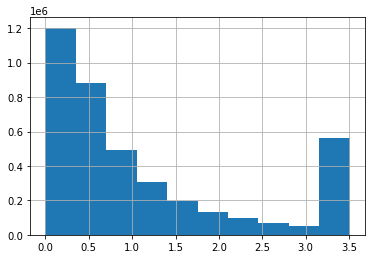

In [56]:
# hist of time spend
behaviour.time_spent_page.hist(bins=10)

<AxesSubplot:xlabel='site_section'>

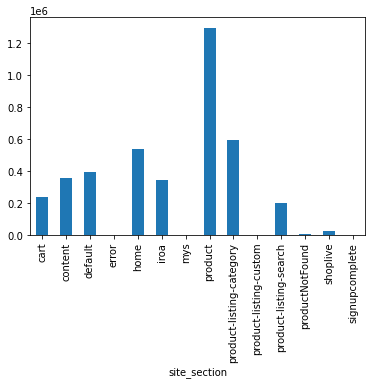

In [57]:
behaviour.groupby(["site_section"])["time_spent_page"].count().plot(kind="bar")

In [58]:
# number of click on each page by an user
behaviour["num_click_Page"]=behaviour.groupby(["user_id","site_section"])["time_stamp"].transform("count")

In [59]:
behaviour.head(2)

,time_stamp,user_id,site_section,next_page_visit_time,time_spent_page,num_click_Page
135522,2017-07-26 00:36:06,342391,product,2017-07-26 06:31:33,3.508333,3
1963729,2017-07-26 06:31:33,342391,home,2017-07-26 06:32:15,0.700000,4


In [60]:
# take site_section into columns and take time spend and Num of page visit as feature
print(behaviour.shape)
behaviour.drop_duplicates(subset=["user_id","site_section"],inplace=True)
print(behaviour.shape)

(4128025, 6)
(1355840, 6)


In [61]:
# change number of click into columns for each different page 
page_click=behaviour.pivot(index="user_id",columns="site_section",values="num_click_Page").reset_index()
page_click.fillna(value=0,inplace=True)


In [62]:
# rename columns 
page_click.columns=[col+"_click" for col in page_click.columns ]
page_click.head(1)

,user_id_click,cart_click,content_click,default_click,error_click,home_click,iroa_click,mys_click,product_click,product-listing-category_click,product-listing-custom_click,product-listing-search_click,productNotFound_click,shoplive_click,signupcomplete_click
0,342391,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# change time spend into columns for each different page 
time_spend=behaviour.pivot(index="user_id",columns="site_section",values="time_spent_page").reset_index()
time_spend.fillna(value=0,inplace=True)

#rename
time_spend.columns=[col+"_Time" for col in time_spend.columns ]
print(time_spend.shape)
time_spend.head(1)

(516927, 15)


,user_id_Time,cart_Time,content_Time,default_Time,error_Time,home_Time,iroa_Time,mys_Time,product_Time,product-listing-category_Time,product-listing-custom_Time,product-listing-search_Time,productNotFound_Time,shoplive_Time,signupcomplete_Time
0,342391,0.0,0.0,0.0,0.0,0.7,0.0,0.0,3.508333,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# merge time spend variables with number of click variable 
behavior_user=page_click.merge(time_spend,left_on="user_id_click",right_on="user_id_Time")
behavior_user.drop(labels="user_id_click",inplace=True,axis=1)
behavior_user.rename(columns={"user_id_Time":"user_id"},inplace=True)

print(behavior_user.shape)

behavior_user.head(1)

(516927, 29)


,cart_click,content_click,default_click,error_click,home_click,iroa_click,mys_click,product_click,product-listing-category_click,product-listing-custom_click,...,home_Time,iroa_Time,mys_Time,product_Time,product-listing-category_Time,product-listing-custom_Time,product-listing-search_Time,productNotFound_Time,shoplive_Time,signupcomplete_Time
0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,...,0.7,0.0,0.0,3.508333,0.0,0.0,0.0,0.0,0.0,0.0


### create target variable 
#### Merge  conversion data to behavior data

In [65]:
conversion.head(1)

,time_stamp,user_id,prod_id,cart_overall
0,2017-07-26 00:00:10,0,A293532,52.14


In [66]:
print(conversion.shape)
conversion.drop_duplicates(subset=["user_id"],inplace=True)
print(conversion.shape)

(79795, 4)
(41009, 4)


In [67]:
final=behavior_user.merge(conversion[["user_id","prod_id"]],on="user_id",how="left")
final_copy=final.copy("deep")
final.shape

(516927, 30)

In [68]:
final.isna().sum()

cart_click                             0
content_click                          0
default_click                          0
error_click                            0
home_click                             0
iroa_click                             0
mys_click                              0
product_click                          0
product-listing-category_click         0
product-listing-custom_click           0
product-listing-search_click           0
productNotFound_click                  0
shoplive_click                         0
signupcomplete_click                   0
user_id                                0
cart_Time                              0
content_Time                           0
default_Time                           0
error_Time                             0
home_Time                              0
iroa_Time                              0
mys_Time                               0
product_Time                           0
product-listing-category_Time          0
product-listing-

In [69]:
final.dtypes

cart_click                        float64
content_click                     float64
default_click                     float64
error_click                       float64
home_click                        float64
iroa_click                        float64
mys_click                         float64
product_click                     float64
product-listing-category_click    float64
product-listing-custom_click      float64
product-listing-search_click      float64
productNotFound_click             float64
shoplive_click                    float64
signupcomplete_click              float64
user_id                             int64
cart_Time                         float64
content_Time                      float64
default_Time                      float64
error_Time                        float64
home_Time                         float64
iroa_Time                         float64
mys_Time                          float64
product_Time                      float64
product-listing-category_Time     

#### Target variable creation

In [70]:
# create target variable using product id 
# if customer buy product after browsering that is categorised as 1 else 0

final["Purchased"]=np.where(final.prod_id.notna(),1,0)
# final["Purchased"]=final["Purchased"].astype(str)

In [71]:
final.isna().sum()

cart_click                             0
content_click                          0
default_click                          0
error_click                            0
home_click                             0
iroa_click                             0
mys_click                              0
product_click                          0
product-listing-category_click         0
product-listing-custom_click           0
product-listing-search_click           0
productNotFound_click                  0
shoplive_click                         0
signupcomplete_click                   0
user_id                                0
cart_Time                              0
content_Time                           0
default_Time                           0
error_Time                             0
home_Time                              0
iroa_Time                              0
mys_Time                               0
product_Time                           0
product-listing-category_Time          0
product-listing-

In [72]:
# drop product id
drop_col=["user_id","prod_id"]
final.drop(labels=drop_col,axis=1,inplace=True)

<AxesSubplot:>

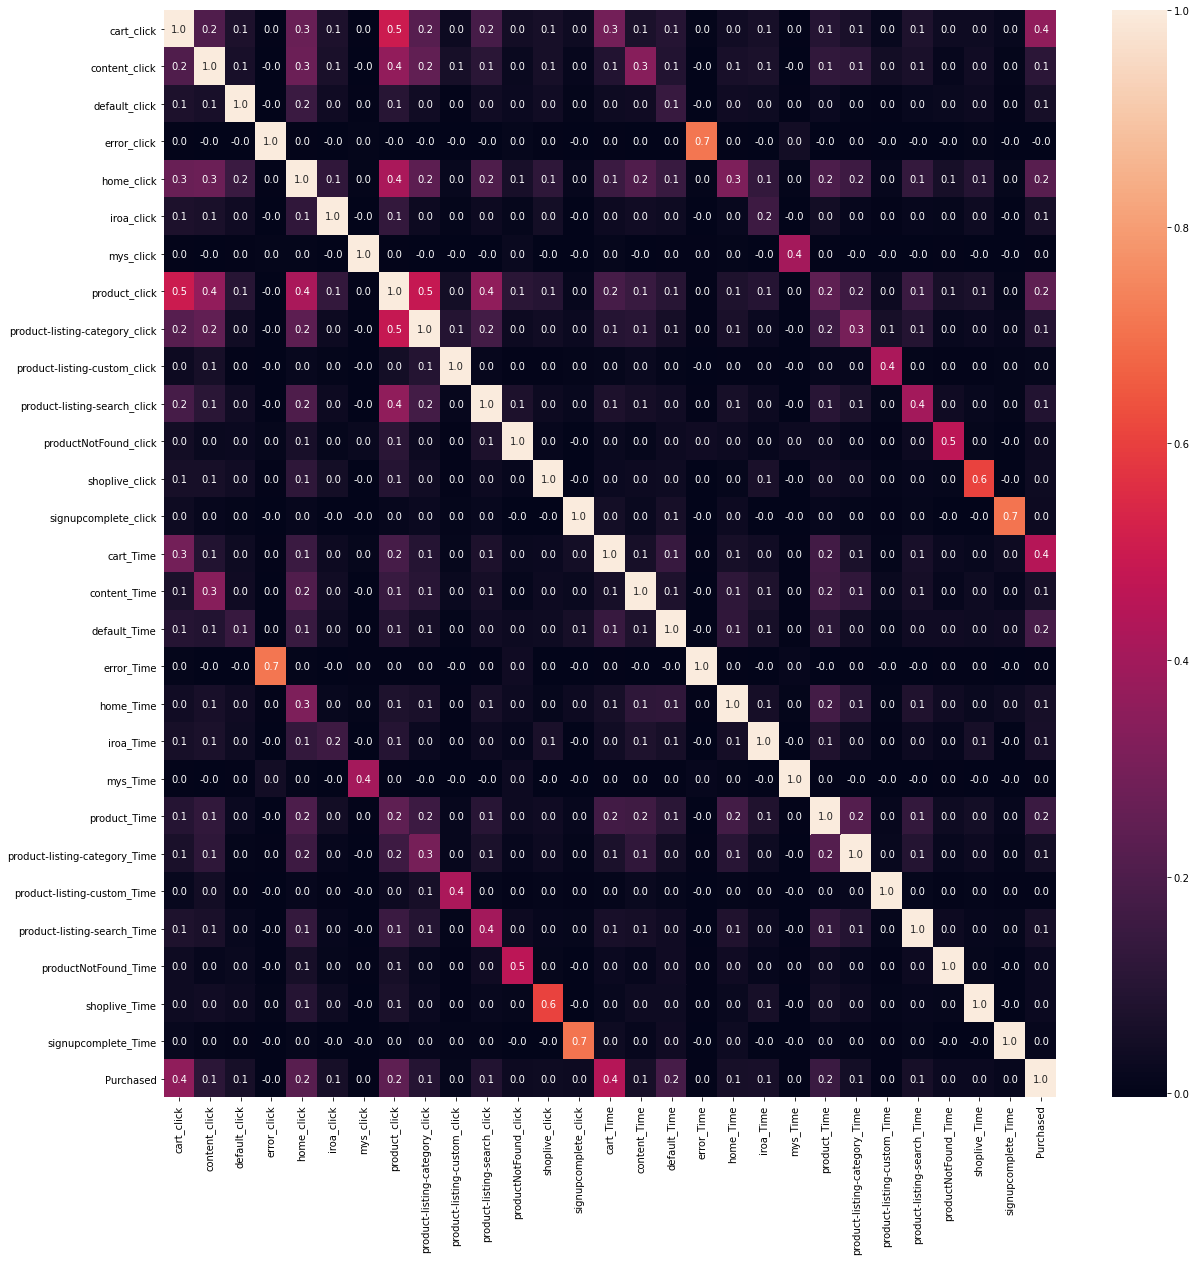

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(final.corr(),annot=True,fmt='.1f')

In [74]:
final.head(1)

,cart_click,content_click,default_click,error_click,home_click,iroa_click,mys_click,product_click,product-listing-category_click,product-listing-custom_click,...,iroa_Time,mys_Time,product_Time,product-listing-category_Time,product-listing-custom_Time,product-listing-search_Time,productNotFound_Time,shoplive_Time,signupcomplete_Time,Purchased
0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.508333,0.0,0.0,0.0,0.0,0.0,0.0,0


In [75]:
# chaeck instances in each classes
final.Purchased.value_counts()

0    476074
1     40853
Name: Purchased, dtype: int64

In [76]:
# take positive classes 
positive_class=final[final.Purchased==1]

# repeat 11 time to macth the number of negative  class instances.

positive_class=pd.concat([positive_class]*11,ignore_index=True)

In [77]:
# upsampling 
final=final.append([positive_class],ignore_index=True)

In [78]:
print(final.shape)
final.Purchased.value_counts()

(966310, 29)


1    490236
0    476074
Name: Purchased, dtype: int64

####  train test split

In [79]:
target=final.Purchased
all_feature=final.drop("Purchased",axis=1)
x_train,x_test,y_train,y_test=train_test_split(all_feature,target,test_size=.2,random_state=1,stratify=target)

In [80]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((773048, 28), (193262, 28), (773048,), (193262,))

#  2. Modeling 

In [81]:
# function to get score
def score(x_train,y_train,x_test,y_test,model):
    
    y_train_pred=model.predict(x_train)
    y_test_pred=model.predict(x_test)
    print("train_R2: {} \n test_R2 :{}".format(model.score(x_train,y_train),model.score(x_test,y_test)))
    print("F-Score for test : {}".format(f1_score(y_test,y_test_pred)))
    print("test precision: {} and test recall: {}".format(precision_score(y_test,y_test_pred),recall_score(y_test,y_test_pred)))
    
# #     print("Train score {}, Test score {}".format(model.score(x_train,y_train),model.score(x_test,y_test))
          
# #     print("confusion matrix_train \n",confusion_matrix(y_train,y_train_pred))
# #     print("confusion matrix_test \n",confusion_matrix(y_test,y_test_pred))
#     print("train precision {} and train recall {}".format(precision_score(y_train,y_train_pred),recall_score(y_train,y_train_pred)))
#     print("test precision {} and test recall {}".format(precision_score(y_test,y_test_pred),recall_score(y_test,y_test_pred)))
#     print("train F-Score {} test F-Score {}".format(f1_score(y_train,y_train_pred),f1_score(y_test,y_test_pred)))

###### Linear model

In [82]:
clas_LM=LogisticRegression()
clas_LM.fit(x_train,y_train)

C:\Users\agupta22\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [83]:
score(x_train,y_train,x_test,y_test,clas_LM)

train_R2: 0.8488205130858627 
 test_R2 :0.8485372189049063
F-Score for test : 0.8414558847424579
test precision: 0.8971622604899345 and test recall: 0.7922628943261905


######  Random forest

In [84]:
clas_RF=RandomForestClassifier(oob_score=True)
clas_RF.fit(x_train,y_train)

RandomForestClassifier(oob_score=True)

<AxesSubplot:>

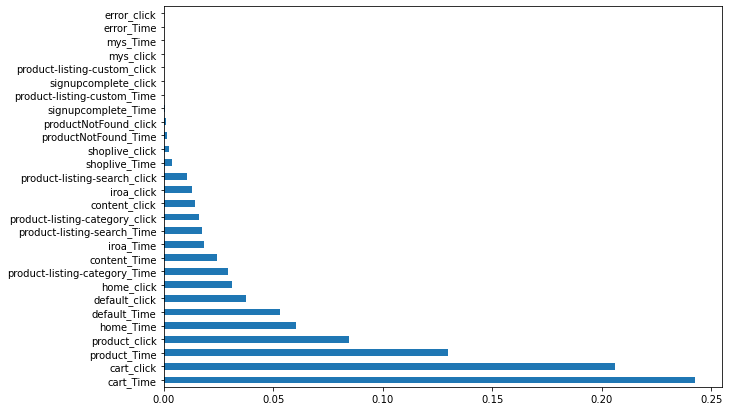

In [85]:
plt.figure(figsize=(10,7))
pd.Series(clas_RF.feature_importances_,index=x_train.columns).sort_values(ascending=False).plot(kind="barh")

<div class="alert alert-block alert-success">

few variables like time spend on cart and product page , Number of click on cart and product page are most important variables

In [86]:
# metrics on test
score(x_train,y_train,x_test,y_test,clas_RF)

train_R2: 0.9856050335813559 
 test_R2 :0.9623826722273391
F-Score for test : 0.9634574206065968
test precision: 0.9498409300389499 and test recall: 0.9774699888828827


###### model Tunning 

In [ ]:
param={"max_features":range(5,8),"max_depth": range(2,5)}
# ,"min_samples_split":[2,3,4,5,6],"min_samples_leaf":[2,3,4,5,6]

In [ ]:
RF_cv=GridSearchCV(estimator=clas_RF,param_grid=param,scoring="f1",cv=10,n_jobs=-1)
RF_cv.fit(x_train,y_train)

In [ ]:
# metrics on test
score(x_train,y_train,x_test,y_test,RF_cv)

In [ ]:
RF_cv.best_params_

In [ ]:
RF_cv.best_score_

In [ ]:
# tunning is not helping in increasing performance .
# RF without tune is taken as final model.

## Probability of user to purchase the product

In [87]:

all_user=final_copy.drop(labels="prod_id",axis=1)
x_all_user=all_user.drop(labels=["user_id"],axis=1)

In [89]:
user_probability=pd.Series(index=all_user.user_id,data=clas_RF.predict_proba(x_all_user)[:,0])

In [90]:
user_probability.shape

(516927,)

In [91]:
user_probability.head(5)

user_id
342391        1.00
420372        1.00
915687        1.00
453960484     0.99
2941287703    0.00
dtype: float64

In [95]:
user_probability.to_csv("user_probability.csv",header="Probability")